In [1]:
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import os

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import dataprocess.data_handler_03 as dh
import assessment.assess_simgraph_09_knn_xgb as asg
import assessment.assess_simgraph_07_nn_lgrg as asg2
import assessment.compare_with_benchmark as bn

# Load and group neuron spike data

In [2]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

# Check the dataset

In [4]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::16]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::2]

def transform_parham(fv):
    return fv[::5]

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/parham/parham3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_parham, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'parham'}

In [5]:
train_num =10
val_num = 5

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=1342)

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))
print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

feature_id:  sift3d
train_num =  10 , val_num =  5
number of features:  384
training data contains 5 points (50.00%) of label 1.
validation data contains 2 points (40.00%) of label 1.
train_smpls =  [2257 1637 1436 1899 1371 2279 2226 1629 1333 2064] 
val_smpls =  [2261 1639 1991 1247 1847]
train_lbls =  [ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1.] 
val_lbls =  [ 1.  1. -1. -1. -1.]
train_des =  [[0.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 4.63960e-02 1.06749e-01
  1.83570e-02]
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 1.99000e-04 2.60000e-05
  1.70000e-04]
 ...
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 6.50000e-05 1.87000e-04
  1.40000e-04]
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 1.13300e-02 1.02030e-02
  8.23600e-03]
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 1.08000e-03 2.24300e-03
  1.63300e-03]] 
val_des =  [[0.0000e+00 0.0000e+00 0.0000e+00 ... 6.0670e-03 8.2110e-03 6.6560e-03]
 [0.0000e+00 0.0000e+00 0.0

# Assess the model's performance with random tests

In [6]:
# model parameters
xgb_params = {'params': {"objective": "binary:logistic", "tree_method": "hist"},
             'num_rounds': 16, 'veval': 10, 'early_stop': 20}

knn_n_neighbors = 3

# randomization parameters
rnd_params = {'train_sizes': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650], 'val_sizes': [50], 'train_its': 100, 'val_its': 1, 'seed': None}

# path to save the results
res_path_knn = '../../data/experiments/comparison/temp/knn/'
res_path_xgb = '../../data/experiments/comparison/temp/xgb/'

In [7]:
# create the knn model
knn = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights='uniform', algorithm='auto')

In [8]:
val_num_res_sg, val_num_err_sg, val_num_res_lgrg, val_num_err_lgrg = asg.assess_sg_model(knn, xgb_params, data_params, rnd_params, res_path_knn, res_path_xgb)

[0]	train-logloss:0.54276
[10]	train-logloss:0.13260
[15]	train-logloss:0.09348
[0]	train-logloss:0.53350
[10]	train-logloss:0.14174
[15]	train-logloss:0.10322
[0]	train-logloss:0.53813
[10]	train-logloss:0.12551
[15]	train-logloss:0.08674
[0]	train-logloss:0.54447
[10]	train-logloss:0.12726
[15]	train-logloss:0.09394
[0]	train-logloss:0.51781
[10]	train-logloss:0.12050
[15]	train-logloss:0.08831
[0]	train-logloss:0.53454
[10]	train-logloss:0.13234
[15]	train-logloss:0.09434
[0]	train-logloss:0.54237
[10]	train-logloss:0.12913
[15]	train-logloss:0.09743
[0]	train-logloss:0.55757
[10]	train-logloss:0.13542
[15]	train-logloss:0.09640
[0]	train-logloss:0.53475
[10]	train-logloss:0.13864
[15]	train-logloss:0.09729
[0]	train-logloss:0.54721
[10]	train-logloss:0.12752
[15]	train-logloss:0.09169
[0]	train-logloss:0.55269
[10]	train-logloss:0.13410
[15]	train-logloss:0.09518
[0]	train-logloss:0.54874
[10]	train-logloss:0.13431
[15]	train-logloss:0.09334
[0]	train-logloss:0.54067
[10]	train-log

In [9]:
knn_title = '{}, k = {}'.format(data_params['feature_id'], knn_n_neighbors)
xgb_title = '{}, n_rounds = {}, early_stop = {}, objective = {}, tree_method = {}'.format(data_params['feature_id'], xgb_params['num_rounds'], xgb_params['early_stop'], xgb_params['params']['objective'], xgb_params['params']['tree_method'])

In [10]:
asg.plot_curves(rnd_params, knn_title, res_path_knn)

In [11]:
asg.plot_curves_without_runtime(rnd_params, xgb_title, res_path_xgb)

# Plot kNN and XGboost validation accuracies together

In [12]:
def gather_train_curves(rnd_params, title, legend, res_path_1, res_path_2):
    # unpack params
    train_sizes = rnd_params['train_sizes']
    val_sizes = rnd_params['val_sizes']
    train_its = rnd_params['train_its']
    val_its = rnd_params['val_its']
    assess_qs = ['min_acc', 'val_acc', 'missed', 'false_alarm']

    # read the first method's training curves
    curves_1 = {}
    errors_1 = {}
    for i in range(len(val_sizes)):
        curves_i = np.loadtxt(res_path_1+'curves/train_'+str(i)+'.txt')
        j = 0
        for quantity in assess_qs:
            if i==0:
                curves_1[quantity] = curves_i[j::8].reshape((1, -1))
                errors_1[quantity] = curves_i[j+1::8].reshape((1, -1))
            else:
                curves_1[quantity] = np.concatenate((curves_1[quantity], [curves_i[j::8]]), axis=0)
                errors_1[quantity] = np.concatenate((errors_1[quantity], [curves_i[j+1::8]]), axis=0)
            j += 2

    # read the second method's training curves
    curves_2 = {}
    errors_2 = {}
    for i in range(len(val_sizes)):
        curves_i = np.loadtxt(res_path_2+'curves/train_'+str(i)+'.txt')
        j = 0
        for quantity in assess_qs:
            if i==0:
                curves_2[quantity] = curves_i[j::8].reshape((1, -1))
                errors_2[quantity] = curves_i[j+1::8].reshape((1, -1))
            else:
                curves_2[quantity] = np.concatenate((curves_2[quantity], [curves_i[j::8]]), axis=0)
                errors_2[quantity] = np.concatenate((errors_2[quantity], [curves_i[j+1::8]]), axis=0)
            j += 2

    # plot training curves
    plt.figure(figsize=(10,4))
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
    for i in range(len(val_sizes)):
        plt.subplot(len(val_sizes), 1, i+1)
        plt.errorbar(train_sizes, curves_1['val_acc'][i], errors_1['val_acc'][i])
        plt.errorbar(train_sizes, curves_2['val_acc'][i], errors_2['val_acc'][i])
        plt.legend(legend)
        plt.xlabel('training set size')
        plt.ylabel('{} val repeats x {} train repeats'.format(val_its, train_its))
        _ = plt.title(title)
    plt.savefig(res_path_1+'val_acc_compare.png')

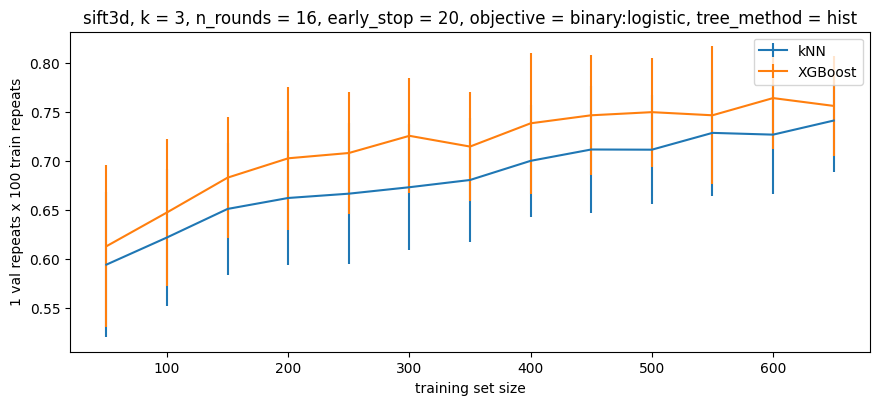

In [13]:
title = '{}, k = {}, n_rounds = {}, early_stop = {}, objective = {}, tree_method = {}'.format(data_params['feature_id'], knn_n_neighbors, xgb_params['num_rounds'], xgb_params['early_stop'], xgb_params['params']['objective'], xgb_params['params']['tree_method'])
legend = ['kNN', 'XGBoost']
gather_train_curves(rnd_params, title, legend, res_path_knn, res_path_xgb)

# Assess NN and LogReg

In [23]:
# graph construction and penalty term parameters
nn_params = {'num_hidden_layers':5, 'num_hidden_units':20, 'num_outs':2, \
             'act_func':bn.relu, 'out_func':bn.softmax, 'loss_func':bn.crossent }
# gradient descent parameters
nn_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':300, 'check_freq':4, 'print_checks':True, 'Theta0':None, \
                  'force_all_its': True, 'threshold': -1}

# randomization parameters
rnd_params = {'train_sizes': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650], 'val_sizes': [50], 'train_its': 100, 'val_its': 1, 'seed': None}

# parameters to visualize the optimized M
fig_params = {}

# path to save the results
res_path_nn = '../../data/experiments/comparison/temp2/nn/'
res_path_lgrg = '../../data/experiments/comparison/temp2/lgrg/'

In [24]:
val_num_res_sg, val_num_err_sg, val_num_res_lgrg, val_num_err_lgrg = asg2.assess_models(data_params, nn_params, nn_opt_params, rnd_params, fig_params, res_path_nn, res_path_lgrg)

   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.68
  68: eps = 1.00e+00;  train loss (E) =  0.68
  72: eps = 5.00e-01;  train loss (E) =  0.67
  76: eps = 5.00e-01;  train loss (E) =  0.66
  80: eps = 2.50e-01;  train loss (E) =  0.64
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 1.00e+00;  train loss (E) =  0.69
  32: eps = 2.50e-01;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 1.25e-01;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 1.25e-01;  train loss (E) =  0.69
  52: eps = 1.25e-01;  train loss (E) =  0.69
  56: eps = 6.25e-02;  train loss (E) =  0.69
  60: eps = 2.50e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 2.50e-01;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 6.25e-02;  train loss (E) =  0.69
  80: eps = 2.50e-01;  train loss (E) =  0.69
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 1.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 1.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 1.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 1.60e+01;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 1.60e+01;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 1.00e+00;  train loss (E) =  0.69
  36: eps = 1.00e+00;  train loss (E) =  0.69
  40: eps = 1.00e+00;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 5.00e-01;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.68
  64: eps = 5.00e-01;  train loss (E) =  0.68
  68: eps = 1.00e+00;  train loss (E) =  0.67
  72: eps = 1.00e+00;  train loss (E) =  0.67
  76: eps = 5.00e-01;  train loss (E) =  0.66
  80: eps = 2.50e-01;  train loss (E) =  0.65
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 5.00e-01;  train loss (E) =  0.69
  12: eps = 2.50e-01;  train loss (E) =  0.69
  16: eps = 5.00e-01;  train loss (E) =  0.69
  20: eps = 5.00e-01;  train loss (E) =  0.69
  24: eps = 5.00e-01;  train loss (E) =  0.69
  28: eps = 2.50e-01;  train loss (E) =  0.69
  32: eps = 5.00e-01;  train loss (E) =  0.69
  36: eps = 5.00e-01;  train loss (E) =  0.69
  40: eps = 5.00e-01;  train loss (E) =  0.69
  44: eps = 5.00e-01;  train loss (E) =  0.69
  48: eps = 5.00e-01;  train loss (E) =  0.69
  52: eps = 5.00e-01;  train loss (E) =  0.69
  56: eps = 5.00e-01;  train loss (E) =  0.69
  60: eps = 5.00e-01;  train loss (E) =  0.69
  64: eps = 5.00e-01;  train loss (E) =  0.69
  68: eps = 5.00e-01;  train loss (E) =  0.69
  72: eps = 5.00e-01;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 3.20e+01;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 5.00e-01;  train loss (E) =  0.69
  20: eps = 5.00e-01;  train loss (E) =  0.69
  24: eps = 5.00e-01;  train loss (E) =  0.69
  28: eps = 1.00e+00;  train loss (E) =  0.69
  32: eps = 2.50e-01;  train loss (E) =  0.69
  36: eps = 2.50e-01;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 2.50e-01;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 2.50e-01;  train loss (E) =  0.69
  56: eps = 2.50e-01;  train loss (E) =  0.69
  60: eps = 5.00e-01;  train loss (E) =  0.69
  64: eps = 2.50e-01;  train loss (E) =  0.69
  68: eps = 5.00e-01;  train loss (E) =  0.69
  72: eps = 5.00e-01;  train loss (E) =  0.69
  76: eps = 5.00e-01;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 1.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 1.00e+00;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.68
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.67
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.50e-01;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 2.50e-01;  train loss (E) =  0.69
  16: eps = 1.25e-01;  train loss (E) =  0.69
  20: eps = 2.50e-01;  train loss (E) =  0.69
  24: eps = 1.25e-01;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 2.50e-01;  train loss (E) =  0.69
  36: eps = 2.50e-01;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 1.25e-01;  train loss (E) =  0.69
  48: eps = 1.25e-01;  train loss (E) =  0.69
  52: eps = 2.50e-01;  train loss (E) =  0.69
  56: eps = 5.00e-01;  train loss (E) =  0.69
  60: eps = 2.50e-01;  train loss (E) =  0.69
  64: eps = 2.50e-01;  train loss (E) =  0.69
  68: eps = 1.25e-01;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 1.25e-01;  train loss (E) =  0.69
  80: eps = 2.50e-01;  train loss (E) =  0.69
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 1.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 5.00e-01;  train loss (E) =  0.68
  56: eps = 5.00e-01;  train loss (E) =  0.68
  60: eps = 1.00e+00;  train loss (E) =  0.68
  64: eps = 5.00e-01;  train loss (E) =  0.67
  68: eps = 2.50e-01;  train loss (E) =  0.66
  72: eps = 2.50e-01;  train loss (E) =  0.66
  76: eps = 2.50e-01;  train loss (E) =  0.65
  80: eps = 1.25e-01;  train loss (E) =  0.65
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 2.50e-01;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 1.60e+01;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 1.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.25e-01;  train loss (E) =  0.69
   4: eps = 3.12e-02;  train loss (E) =  0.69
   8: eps = 3.12e-02;  train loss (E) =  0.69
  12: eps = 3.12e-02;  train loss (E) =  0.69
  16: eps = 3.12e-02;  train loss (E) =  0.69
  20: eps = 3.12e-02;  train loss (E) =  0.69
  24: eps = 1.56e-02;  train loss (E) =  0.69
  28: eps = 1.56e-02;  train loss (E) =  0.69
  32: eps = 1.56e-02;  train loss (E) =  0.69
  36: eps = 1.56e-02;  train loss (E) =  0.69
  40: eps = 1.56e-02;  train loss (E) =  0.69
  44: eps = 1.56e-02;  train loss (E) =  0.69
  48: eps = 1.56e-02;  train loss (E) =  0.69
  52: eps = 7.81e-03;  train loss (E) =  0.69
  56: eps = 1.56e-02;  train loss (E) =  0.69
  60: eps = 1.56e-02;  train loss (E) =  0.69
  64: eps = 3.12e-02;  train loss (E) =  0.69
  68: eps = 1.56e-02;  train loss (E) =  0.69
  72: eps = 1.56e-02;  train loss (E) =  0.69
  76: eps = 1.56e-02;  train loss (E) =  0.69
  80: eps = 3.12e-02;  train loss (E) =  0.69
  84: eps = 3.12e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 1.25e-01;  train loss (E) =  0.69
  20: eps = 2.50e-01;  train loss (E) =  0.69
  24: eps = 2.50e-01;  train loss (E) =  0.69
  28: eps = 2.50e-01;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 2.50e-01;  train loss (E) =  0.69
  48: eps = 1.25e-01;  train loss (E) =  0.69
  52: eps = 1.25e-01;  train loss (E) =  0.69
  56: eps = 6.25e-02;  train loss (E) =  0.69
  60: eps = 1.25e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 1.25e-01;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 1.25e-01;  train loss (E) =  0.69
  80: eps = 6.25e-02;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.68
  72: eps = 5.00e-01;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.67
  80: eps = 5.00e-01;  train loss (E) =  0.67
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 1.60e+01;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.68
  68: eps = 5.00e-01;  train loss (E) =  0.68
  72: eps = 5.00e-01;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.67
  80: eps = 2.50e-01;  train loss (E) =  0.67
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.25e-01;  train loss (E) =  0.69
   8: eps = 3.12e-02;  train loss (E) =  0.69
  12: eps = 3.12e-02;  train loss (E) =  0.69
  16: eps = 3.12e-02;  train loss (E) =  0.69
  20: eps = 6.25e-02;  train loss (E) =  0.69
  24: eps = 6.25e-02;  train loss (E) =  0.69
  28: eps = 6.25e-02;  train loss (E) =  0.69
  32: eps = 6.25e-02;  train loss (E) =  0.69
  36: eps = 3.12e-02;  train loss (E) =  0.69
  40: eps = 6.25e-02;  train loss (E) =  0.69
  44: eps = 6.25e-02;  train loss (E) =  0.69
  48: eps = 6.25e-02;  train loss (E) =  0.69
  52: eps = 3.12e-02;  train loss (E) =  0.69
  56: eps = 6.25e-02;  train loss (E) =  0.69
  60: eps = 6.25e-02;  train loss (E) =  0.69
  64: eps = 3.12e-02;  train loss (E) =  0.69
  68: eps = 6.25e-02;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 2.50e-01;  train loss (E) =  0.69
  80: eps = 2.50e-01;  train loss (E) =  0.69
  84: eps = 6.25e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 5.00e-01;  train loss (E) =  0.69
  12: eps = 2.50e-01;  train loss (E) =  0.69
  16: eps = 2.50e-01;  train loss (E) =  0.69
  20: eps = 1.25e-01;  train loss (E) =  0.69
  24: eps = 5.00e-01;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 1.25e-01;  train loss (E) =  0.69
  44: eps = 1.25e-01;  train loss (E) =  0.69
  48: eps = 6.25e-02;  train loss (E) =  0.69
  52: eps = 2.50e-01;  train loss (E) =  0.69
  56: eps = 1.25e-01;  train loss (E) =  0.69
  60: eps = 1.25e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 1.25e-01;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 1.25e-01;  train loss (E) =  0.69
  80: eps = 1.25e-01;  train loss (E) =  0.69
  84: eps = 6.25e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.50e-01;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.68
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 7.81e-03;  train loss (E) =  0.69
   4: eps = 3.91e-03;  train loss (E) =  0.69
   8: eps = 3.91e-03;  train loss (E) =  0.69
  12: eps = 3.91e-03;  train loss (E) =  0.69
  16: eps = 7.81e-03;  train loss (E) =  0.69
  20: eps = 1.56e-02;  train loss (E) =  0.69
  24: eps = 3.91e-03;  train loss (E) =  0.69
  28: eps = 3.91e-03;  train loss (E) =  0.69
  32: eps = 7.81e-03;  train loss (E) =  0.69
  36: eps = 1.56e-02;  train loss (E) =  0.69
  40: eps = 7.81e-03;  train loss (E) =  0.69
  44: eps = 7.81e-03;  train loss (E) =  0.69
  48: eps = 7.81e-03;  train loss (E) =  0.69
  52: eps = 7.81e-03;  train loss (E) =  0.69
  56: eps = 1.95e-03;  train loss (E) =  0.69
  60: eps = 3.91e-03;  train loss (E) =  0.69
  64: eps = 3.91e-03;  train loss (E) =  0.69
  68: eps = 3.91e-03;  train loss (E) =  0.69
  72: eps = 3.91e-03;  train loss (E) =  0.69
  76: eps = 7.81e-03;  train loss (E) =  0.69
  80: eps = 3.91e-03;  train loss (E) =  0.69
  84: eps = 3.91e-03;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.68
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.50e-01;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.68
  68: eps = 5.00e-01;  train loss (E) =  0.68
  72: eps = 1.00e+00;  train loss (E) =  0.67
  76: eps = 5.00e-01;  train loss (E) =  0.67
  80: eps = 5.00e-01;  train loss (E) =  0.66
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 3.12e-02;  train loss (E) =  0.69
   8: eps = 1.56e-02;  train loss (E) =  0.69
  12: eps = 3.12e-02;  train loss (E) =  0.69
  16: eps = 1.56e-02;  train loss (E) =  0.69
  20: eps = 3.12e-02;  train loss (E) =  0.69
  24: eps = 1.25e-01;  train loss (E) =  0.69
  28: eps = 3.12e-02;  train loss (E) =  0.69
  32: eps = 1.56e-02;  train loss (E) =  0.69
  36: eps = 1.56e-02;  train loss (E) =  0.69
  40: eps = 6.25e-02;  train loss (E) =  0.69
  44: eps = 3.12e-02;  train loss (E) =  0.69
  48: eps = 1.56e-02;  train loss (E) =  0.69
  52: eps = 1.56e-02;  train loss (E) =  0.69
  56: eps = 1.56e-02;  train loss (E) =  0.69
  60: eps = 1.56e-02;  train loss (E) =  0.69
  64: eps = 3.12e-02;  train loss (E) =  0.69
  68: eps = 1.56e-02;  train loss (E) =  0.69
  72: eps = 1.56e-02;  train loss (E) =  0.69
  76: eps = 7.81e-03;  train loss (E) =  0.69
  80: eps = 1.25e-01;  train loss (E) =  0.69
  84: eps = 3.12e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.56e-02;  train loss (E) =  0.69
   8: eps = 7.81e-03;  train loss (E) =  0.69
  12: eps = 7.81e-03;  train loss (E) =  0.69
  16: eps = 7.81e-03;  train loss (E) =  0.69
  20: eps = 7.81e-03;  train loss (E) =  0.69
  24: eps = 1.56e-02;  train loss (E) =  0.69
  28: eps = 7.81e-03;  train loss (E) =  0.69
  32: eps = 1.56e-02;  train loss (E) =  0.69
  36: eps = 1.56e-02;  train loss (E) =  0.69
  40: eps = 1.56e-02;  train loss (E) =  0.69
  44: eps = 7.81e-03;  train loss (E) =  0.69
  48: eps = 7.81e-03;  train loss (E) =  0.69
  52: eps = 7.81e-03;  train loss (E) =  0.69
  56: eps = 1.56e-02;  train loss (E) =  0.69
  60: eps = 7.81e-03;  train loss (E) =  0.69
  64: eps = 7.81e-03;  train loss (E) =  0.69
  68: eps = 3.91e-03;  train loss (E) =  0.69
  72: eps = 7.81e-03;  train loss (E) =  0.69
  76: eps = 3.91e-03;  train loss (E) =  0.69
  80: eps = 3.91e-03;  train loss (E) =  0.69
  84: eps = 3.91e-03;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 2.50e-01;  train loss (E) =  0.69
  24: eps = 1.25e-01;  train loss (E) =  0.69
  28: eps = 2.50e-01;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 1.25e-01;  train loss (E) =  0.69
  44: eps = 1.25e-01;  train loss (E) =  0.69
  48: eps = 2.50e-01;  train loss (E) =  0.69
  52: eps = 2.50e-01;  train loss (E) =  0.69
  56: eps = 2.50e-01;  train loss (E) =  0.69
  60: eps = 1.25e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 1.25e-01;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 1.25e-01;  train loss (E) =  0.69
  80: eps = 2.50e-01;  train loss (E) =  0.69
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 1.60e+01;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 1.60e+01;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 1.60e+01;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 1.60e+01;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.50e-01;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 1.60e+01;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.60e+01;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.68
  56: eps = 2.00e+00;  train loss (E) =  0.68
  60: eps = 2.50e-01;  train loss (E) =  0.68
  64: eps = 2.50e-01;  train loss (E) =  0.67
  68: eps = 2.50e-01;  train loss (E) =  0.67
  72: eps = 2.50e-01;  train loss (E) =  0.67
  76: eps = 2.50e-01;  train loss (E) =  0.67
  80: eps = 2.50e-01;  train loss (E) =  0.66
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.25e-01;  train loss (E) =  0.69
   8: eps = 2.50e-01;  train loss (E) =  0.69
  12: eps = 3.12e-02;  train loss (E) =  0.69
  16: eps = 6.25e-02;  train loss (E) =  0.69
  20: eps = 6.25e-02;  train loss (E) =  0.69
  24: eps = 2.50e-01;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 1.25e-01;  train loss (E) =  0.69
  48: eps = 2.50e-01;  train loss (E) =  0.69
  52: eps = 1.25e-01;  train loss (E) =  0.69
  56: eps = 2.50e-01;  train loss (E) =  0.69
  60: eps = 2.50e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 5.00e-01;  train loss (E) =  0.69
  72: eps = 6.25e-02;  train loss (E) =  0.69
  76: eps = 6.25e-02;  train loss (E) =  0.69
  80: eps = 1.25e-01;  train loss (E) =  0.69
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 1.25e-01;  train loss (E) =  0.69
  12: eps = 1.25e-01;  train loss (E) =  0.69
  16: eps = 6.25e-02;  train loss (E) =  0.69
  20: eps = 1.25e-01;  train loss (E) =  0.69
  24: eps = 1.25e-01;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 2.50e-01;  train loss (E) =  0.69
  48: eps = 1.25e-01;  train loss (E) =  0.69
  52: eps = 1.25e-01;  train loss (E) =  0.69
  56: eps = 1.25e-01;  train loss (E) =  0.69
  60: eps = 1.25e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 1.25e-01;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 1.25e-01;  train loss (E) =  0.69
  80: eps = 1.25e-01;  train loss (E) =  0.69
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.25e-01;  train loss (E) =  0.69
   8: eps = 1.25e-01;  train loss (E) =  0.69
  12: eps = 3.12e-02;  train loss (E) =  0.69
  16: eps = 6.25e-02;  train loss (E) =  0.69
  20: eps = 3.12e-02;  train loss (E) =  0.69
  24: eps = 6.25e-02;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 6.25e-02;  train loss (E) =  0.69
  36: eps = 6.25e-02;  train loss (E) =  0.69
  40: eps = 6.25e-02;  train loss (E) =  0.69
  44: eps = 6.25e-02;  train loss (E) =  0.69
  48: eps = 6.25e-02;  train loss (E) =  0.69
  52: eps = 6.25e-02;  train loss (E) =  0.69
  56: eps = 6.25e-02;  train loss (E) =  0.69
  60: eps = 3.12e-02;  train loss (E) =  0.69
  64: eps = 6.25e-02;  train loss (E) =  0.69
  68: eps = 6.25e-02;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 6.25e-02;  train loss (E) =  0.69
  80: eps = 6.25e-02;  train loss (E) =  0.69
  84: eps = 6.25e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.50e-01;  train loss (E) =  0.69
  12: eps = 5.00e-01;  train loss (E) =  0.69
  16: eps = 5.00e-01;  train loss (E) =  0.69
  20: eps = 1.00e+00;  train loss (E) =  0.69
  24: eps = 1.00e+00;  train loss (E) =  0.69
  28: eps = 1.00e+00;  train loss (E) =  0.69
  32: eps = 5.00e-01;  train loss (E) =  0.69
  36: eps = 5.00e-01;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 5.00e-01;  train loss (E) =  0.69
  48: eps = 2.50e-01;  train loss (E) =  0.69
  52: eps = 5.00e-01;  train loss (E) =  0.69
  56: eps = 5.00e-01;  train loss (E) =  0.69
  60: eps = 2.50e-01;  train loss (E) =  0.69
  64: eps = 2.50e-01;  train loss (E) =  0.69
  68: eps = 2.50e-01;  train loss (E) =  0.69
  72: eps = 2.50e-01;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 3.12e-02;  train loss (E) =  0.69
   4: eps = 1.56e-02;  train loss (E) =  0.69
   8: eps = 1.56e-02;  train loss (E) =  0.69
  12: eps = 3.12e-02;  train loss (E) =  0.69
  16: eps = 2.50e-01;  train loss (E) =  0.69
  20: eps = 1.56e-02;  train loss (E) =  0.69
  24: eps = 3.12e-02;  train loss (E) =  0.69
  28: eps = 1.56e-02;  train loss (E) =  0.69
  32: eps = 1.56e-02;  train loss (E) =  0.69
  36: eps = 3.12e-02;  train loss (E) =  0.69
  40: eps = 1.56e-02;  train loss (E) =  0.69
  44: eps = 1.56e-02;  train loss (E) =  0.69
  48: eps = 1.56e-02;  train loss (E) =  0.69
  52: eps = 7.81e-03;  train loss (E) =  0.69
  56: eps = 3.12e-02;  train loss (E) =  0.69
  60: eps = 3.12e-02;  train loss (E) =  0.69
  64: eps = 3.12e-02;  train loss (E) =  0.69
  68: eps = 3.12e-02;  train loss (E) =  0.69
  72: eps = 6.25e-02;  train loss (E) =  0.69
  76: eps = 1.25e-01;  train loss (E) =  0.69
  80: eps = 1.56e-02;  train loss (E) =  0.69
  84: eps = 1.56e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.60e+01;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.25e-01;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 5.00e-01;  train loss (E) =  0.69
  24: eps = 2.50e-01;  train loss (E) =  0.69
  28: eps = 1.00e+00;  train loss (E) =  0.69
  32: eps = 1.00e+00;  train loss (E) =  0.69
  36: eps = 5.00e-01;  train loss (E) =  0.69
  40: eps = 5.00e-01;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 2.50e-01;  train loss (E) =  0.69
  52: eps = 5.00e-01;  train loss (E) =  0.69
  56: eps = 2.50e-01;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.50e-01;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 5.00e-01;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.69
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.68
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 1.56e-02;  train loss (E) =  0.69
  24: eps = 7.81e-03;  train loss (E) =  0.69
  28: eps = 1.56e-02;  train loss (E) =  0.69
  32: eps = 7.81e-03;  train loss (E) =  0.69
  36: eps = 1.56e-02;  train loss (E) =  0.69
  40: eps = 3.91e-03;  train loss (E) =  0.69
  44: eps = 1.56e-02;  train loss (E) =  0.69
  48: eps = 7.81e-03;  train loss (E) =  0.69
  52: eps = 7.81e-03;  train loss (E) =  0.69
  56: eps = 7.81e-03;  train loss (E) =  0.69
  60: eps = 1.56e-02;  train loss (E) =  0.69
  64: eps = 7.81e-03;  train loss (E) =  0.69
  68: eps = 7.81e-03;  train loss (E) =  0.69
  72: eps = 7.81e-03;  train loss (E) =  0.69
  76: eps = 1.56e-02;  train loss (E) =  0.69
  80: eps = 7.81e-03;  train loss (E) =  0.69
  84: eps = 7.81e-03;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.68
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.50e-01;  train loss (E) =  0.69
   8: eps = 1.25e-01;  train loss (E) =  0.69
  12: eps = 1.25e-01;  train loss (E) =  0.69
  16: eps = 6.25e-02;  train loss (E) =  0.69
  20: eps = 3.12e-02;  train loss (E) =  0.69
  24: eps = 1.25e-01;  train loss (E) =  0.69
  28: eps = 6.25e-02;  train loss (E) =  0.69
  32: eps = 6.25e-02;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 3.12e-02;  train loss (E) =  0.69
  44: eps = 6.25e-02;  train loss (E) =  0.69
  48: eps = 1.25e-01;  train loss (E) =  0.69
  52: eps = 6.25e-02;  train loss (E) =  0.69
  56: eps = 1.25e-01;  train loss (E) =  0.69
  60: eps = 1.25e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 1.25e-01;  train loss (E) =  0.69
  72: eps = 6.25e-02;  train loss (E) =  0.69
  76: eps = 3.12e-02;  train loss (E) =  0.69
  80: eps = 6.25e-02;  train loss (E) =  0.69
  84: eps = 6.25e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.60e+01;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.25e-01;  train loss (E) =  0.69
   4: eps = 1.56e-02;  train loss (E) =  0.69
   8: eps = 7.81e-03;  train loss (E) =  0.69
  12: eps = 1.56e-02;  train loss (E) =  0.69
  16: eps = 7.81e-03;  train loss (E) =  0.69
  20: eps = 7.81e-03;  train loss (E) =  0.69
  24: eps = 1.56e-02;  train loss (E) =  0.69
  28: eps = 7.81e-03;  train loss (E) =  0.69
  32: eps = 3.91e-03;  train loss (E) =  0.69
  36: eps = 3.91e-03;  train loss (E) =  0.69
  40: eps = 7.81e-03;  train loss (E) =  0.69
  44: eps = 7.81e-03;  train loss (E) =  0.69
  48: eps = 3.91e-03;  train loss (E) =  0.69
  52: eps = 3.91e-03;  train loss (E) =  0.69
  56: eps = 3.91e-03;  train loss (E) =  0.69
  60: eps = 7.81e-03;  train loss (E) =  0.69
  64: eps = 7.81e-03;  train loss (E) =  0.69
  68: eps = 7.81e-03;  train loss (E) =  0.69
  72: eps = 1.56e-02;  train loss (E) =  0.69
  76: eps = 7.81e-03;  train loss (E) =  0.69
  80: eps = 7.81e-03;  train loss (E) =  0.69
  84: eps = 7.81e-03;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.68
  60: eps = 1.00e+00;  train loss (E) =  0.68
  64: eps = 2.00e+00;  train loss (E) =  0.68
  68: eps = 5.00e-01;  train loss (E) =  0.67
  72: eps = 5.00e-01;  train loss (E) =  0.67
  76: eps = 2.50e-01;  train loss (E) =  0.67
  80: eps = 2.50e-01;  train loss (E) =  0.66
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.68
  68: eps = 2.00e+00;  train loss (E) =  0.68
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.67
  80: eps = 2.50e-01;  train loss (E) =  0.67
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 3.12e-02;  train loss (E) =  0.69
   8: eps = 5.00e-01;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 1.60e+01;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 1.60e+01;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.50e-01;  train loss (E) =  0.69
   4: eps = 1.25e-01;  train loss (E) =  0.69
   8: eps = 6.25e-02;  train loss (E) =  0.69
  12: eps = 1.25e-01;  train loss (E) =  0.69
  16: eps = 6.25e-02;  train loss (E) =  0.69
  20: eps = 1.25e-01;  train loss (E) =  0.69
  24: eps = 6.25e-02;  train loss (E) =  0.69
  28: eps = 6.25e-02;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 6.25e-02;  train loss (E) =  0.69
  40: eps = 6.25e-02;  train loss (E) =  0.69
  44: eps = 3.12e-02;  train loss (E) =  0.69
  48: eps = 6.25e-02;  train loss (E) =  0.69
  52: eps = 6.25e-02;  train loss (E) =  0.69
  56: eps = 6.25e-02;  train loss (E) =  0.69
  60: eps = 3.12e-02;  train loss (E) =  0.69
  64: eps = 3.12e-02;  train loss (E) =  0.69
  68: eps = 6.25e-02;  train loss (E) =  0.69
  72: eps = 3.12e-02;  train loss (E) =  0.69
  76: eps = 3.12e-02;  train loss (E) =  0.69
  80: eps = 6.25e-02;  train loss (E) =  0.69
  84: eps = 3.12e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 5.00e-01;  train loss (E) =  0.69
  24: eps = 5.00e-01;  train loss (E) =  0.69
  28: eps = 5.00e-01;  train loss (E) =  0.69
  32: eps = 5.00e-01;  train loss (E) =  0.69
  36: eps = 5.00e-01;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 1.60e+01;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 1.60e+01;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 5.00e-01;  train loss (E) =  0.69
  24: eps = 5.00e-01;  train loss (E) =  0.69
  28: eps = 5.00e-01;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 5.00e-01;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 5.00e-01;  train loss (E) =  0.69
  48: eps = 5.00e-01;  train loss (E) =  0.69
  52: eps = 2.50e-01;  train loss (E) =  0.69
  56: eps = 2.50e-01;  train loss (E) =  0.69
  60: eps = 2.50e-01;  train loss (E) =  0.69
  64: eps = 5.00e-01;  train loss (E) =  0.69
  68: eps = 5.00e-01;  train loss (E) =  0.69
  72: eps = 5.00e-01;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 1.00e+00;  train loss (E) =  0.69
  28: eps = 1.00e+00;  train loss (E) =  0.69
  32: eps = 1.00e+00;  train loss (E) =  0.69
  36: eps = 1.00e+00;  train loss (E) =  0.69
  40: eps = 5.00e-01;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 5.00e-01;  train loss (E) =  0.69
  60: eps = 5.00e-01;  train loss (E) =  0.69
  64: eps = 5.00e-01;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.68
  64: eps = 5.00e-01;  train loss (E) =  0.68
  68: eps = 5.00e-01;  train loss (E) =  0.67
  72: eps = 5.00e-01;  train loss (E) =  0.67
  76: eps = 5.00e-01;  train loss (E) =  0.67
  80: eps = 2.50e-01;  train loss (E) =  0.66
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 2.50e-01;  train loss (E) =  0.69
  12: eps = 1.25e-01;  train loss (E) =  0.69
  16: eps = 1.25e-01;  train loss (E) =  0.69
  20: eps = 1.25e-01;  train loss (E) =  0.69
  24: eps = 1.25e-01;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 2.50e-01;  train loss (E) =  0.69
  40: eps = 1.25e-01;  train loss (E) =  0.69
  44: eps = 1.25e-01;  train loss (E) =  0.69
  48: eps = 1.25e-01;  train loss (E) =  0.69
  52: eps = 6.25e-02;  train loss (E) =  0.69
  56: eps = 6.25e-02;  train loss (E) =  0.69
  60: eps = 1.25e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 6.25e-02;  train loss (E) =  0.69
  72: eps = 6.25e-02;  train loss (E) =  0.69
  76: eps = 6.25e-02;  train loss (E) =  0.69
  80: eps = 6.25e-02;  train loss (E) =  0.69
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 1.00e+00;  train loss (E) =  0.69
  44: eps = 1.60e+01;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 2.00e+00;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 1.60e+01;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.68
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 1.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.68
  60: eps = 5.00e-01;  train loss (E) =  0.68
  64: eps = 1.00e+00;  train loss (E) =  0.68
  68: eps = 5.00e-01;  train loss (E) =  0.67
  72: eps = 5.00e-01;  train loss (E) =  0.67
  76: eps = 1.00e+00;  train loss (E) =  0.66
  80: eps = 5.00e-01;  train loss (E) =  0.66
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.68
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.50e-01;  train loss (E) =  0.69
  20: eps = 2.50e-01;  train loss (E) =  0.69
  24: eps = 1.25e-01;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 6.25e-02;  train loss (E) =  0.69
  36: eps = 6.25e-02;  train loss (E) =  0.69
  40: eps = 1.25e-01;  train loss (E) =  0.69
  44: eps = 1.25e-01;  train loss (E) =  0.69
  48: eps = 1.25e-01;  train loss (E) =  0.69
  52: eps = 1.25e-01;  train loss (E) =  0.69
  56: eps = 1.25e-01;  train loss (E) =  0.69
  60: eps = 5.00e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 2.50e-01;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 1.25e-01;  train loss (E) =  0.69
  80: eps = 2.50e-01;  train loss (E) =  0.69
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.25e-01;  train loss (E) =  0.69
   8: eps = 1.25e-01;  train loss (E) =  0.69
  12: eps = 2.50e-01;  train loss (E) =  0.69
  16: eps = 1.25e-01;  train loss (E) =  0.69
  20: eps = 1.25e-01;  train loss (E) =  0.69
  24: eps = 2.50e-01;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 5.00e-01;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 1.25e-01;  train loss (E) =  0.69
  48: eps = 1.25e-01;  train loss (E) =  0.69
  52: eps = 2.50e-01;  train loss (E) =  0.69
  56: eps = 6.25e-02;  train loss (E) =  0.69
  60: eps = 1.25e-01;  train loss (E) =  0.69
  64: eps = 6.25e-02;  train loss (E) =  0.69
  68: eps = 1.25e-01;  train loss (E) =  0.69
  72: eps = 6.25e-02;  train loss (E) =  0.69
  76: eps = 1.25e-01;  train loss (E) =  0.69
  80: eps = 1.25e-01;  train loss (E) =  0.69
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 5.00e-01;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 5.00e-01;  train loss (E) =  0.69
  20: eps = 2.50e-01;  train loss (E) =  0.69
  24: eps = 1.00e+00;  train loss (E) =  0.69
  28: eps = 2.50e-01;  train loss (E) =  0.69
  32: eps = 2.50e-01;  train loss (E) =  0.69
  36: eps = 5.00e-01;  train loss (E) =  0.69
  40: eps = 5.00e-01;  train loss (E) =  0.69
  44: eps = 5.00e-01;  train loss (E) =  0.69
  48: eps = 5.00e-01;  train loss (E) =  0.69
  52: eps = 5.00e-01;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 5.00e-01;  train loss (E) =  0.69
  68: eps = 5.00e-01;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 5.00e-01;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 2.50e-01;  train loss (E) =  0.69
  12: eps = 2.50e-01;  train loss (E) =  0.69
  16: eps = 1.25e-01;  train loss (E) =  0.69
  20: eps = 1.25e-01;  train loss (E) =  0.69
  24: eps = 2.50e-01;  train loss (E) =  0.69
  28: eps = 2.50e-01;  train loss (E) =  0.69
  32: eps = 2.50e-01;  train loss (E) =  0.69
  36: eps = 3.12e-02;  train loss (E) =  0.69
  40: eps = 3.12e-02;  train loss (E) =  0.69
  44: eps = 3.12e-02;  train loss (E) =  0.69
  48: eps = 3.12e-02;  train loss (E) =  0.69
  52: eps = 3.12e-02;  train loss (E) =  0.69
  56: eps = 3.12e-02;  train loss (E) =  0.69
  60: eps = 3.12e-02;  train loss (E) =  0.69
  64: eps = 3.12e-02;  train loss (E) =  0.69
  68: eps = 3.12e-02;  train loss (E) =  0.69
  72: eps = 3.12e-02;  train loss (E) =  0.69
  76: eps = 3.12e-02;  train loss (E) =  0.69
  80: eps = 3.12e-02;  train loss (E) =  0.69
  84: eps = 3.12e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 5.00e-01;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 5.00e-01;  train loss (E) =  0.69
  24: eps = 5.00e-01;  train loss (E) =  0.69
  28: eps = 2.50e-01;  train loss (E) =  0.69
  32: eps = 5.00e-01;  train loss (E) =  0.69
  36: eps = 2.50e-01;  train loss (E) =  0.69
  40: eps = 1.25e-01;  train loss (E) =  0.69
  44: eps = 2.50e-01;  train loss (E) =  0.69
  48: eps = 2.50e-01;  train loss (E) =  0.69
  52: eps = 2.50e-01;  train loss (E) =  0.69
  56: eps = 1.25e-01;  train loss (E) =  0.69
  60: eps = 2.50e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 2.50e-01;  train loss (E) =  0.69
  72: eps = 2.50e-01;  train loss (E) =  0.69
  76: eps = 2.50e-01;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.69
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 1.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 1.60e+01;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.56e-02;  train loss (E) =  0.69
   8: eps = 3.12e-02;  train loss (E) =  0.69
  12: eps = 1.25e-01;  train loss (E) =  0.69
  16: eps = 1.56e-02;  train loss (E) =  0.69
  20: eps = 7.81e-03;  train loss (E) =  0.69
  24: eps = 1.56e-02;  train loss (E) =  0.69
  28: eps = 1.56e-02;  train loss (E) =  0.69
  32: eps = 1.56e-02;  train loss (E) =  0.69
  36: eps = 7.81e-03;  train loss (E) =  0.69
  40: eps = 7.81e-03;  train loss (E) =  0.69
  44: eps = 3.91e-03;  train loss (E) =  0.69
  48: eps = 3.91e-03;  train loss (E) =  0.69
  52: eps = 3.91e-03;  train loss (E) =  0.69
  56: eps = 3.91e-03;  train loss (E) =  0.69
  60: eps = 3.91e-03;  train loss (E) =  0.69
  64: eps = 3.91e-03;  train loss (E) =  0.69
  68: eps = 3.91e-03;  train loss (E) =  0.69
  72: eps = 3.91e-03;  train loss (E) =  0.69
  76: eps = 3.91e-03;  train loss (E) =  0.69
  80: eps = 6.25e-02;  train loss (E) =  0.69
  84: eps = 3.91e-03;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 1.00e+00;  train loss (E) =  0.69
  44: eps = 6.25e-02;  train loss (E) =  0.69
  48: eps = 6.25e-02;  train loss (E) =  0.69
  52: eps = 6.25e-02;  train loss (E) =  0.69
  56: eps = 3.12e-02;  train loss (E) =  0.69
  60: eps = 3.12e-02;  train loss (E) =  0.69
  64: eps = 6.25e-02;  train loss (E) =  0.69
  68: eps = 6.25e-02;  train loss (E) =  0.69
  72: eps = 3.12e-02;  train loss (E) =  0.69
  76: eps = 3.12e-02;  train loss (E) =  0.69
  80: eps = 3.12e-02;  train loss (E) =  0.69
  84: eps = 1.25e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.25e-01;  train loss (E) =  0.69
   8: eps = 2.50e-01;  train loss (E) =  0.69
  12: eps = 5.00e-01;  train loss (E) =  0.69
  16: eps = 2.50e-01;  train loss (E) =  0.69
  20: eps = 1.00e+00;  train loss (E) =  0.69
  24: eps = 1.25e-01;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 1.25e-01;  train loss (E) =  0.69
  44: eps = 5.00e-01;  train loss (E) =  0.69
  48: eps = 5.00e-01;  train loss (E) =  0.69
  52: eps = 2.50e-01;  train loss (E) =  0.69
  56: eps = 1.25e-01;  train loss (E) =  0.69
  60: eps = 1.25e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 1.25e-01;  train loss (E) =  0.69
  72: eps = 2.50e-01;  train loss (E) =  0.69
  76: eps = 5.00e-01;  train loss (E) =  0.69
  80: eps = 1.25e-01;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.50e-01;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.68
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 5.00e-01;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.50e-01;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 1.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.68
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 1.56e-02;  train loss (E) =  0.69
  20: eps = 7.81e-03;  train loss (E) =  0.69
  24: eps = 7.81e-03;  train loss (E) =  0.69
  28: eps = 7.81e-03;  train loss (E) =  0.69
  32: eps = 7.81e-03;  train loss (E) =  0.69
  36: eps = 1.56e-02;  train loss (E) =  0.69
  40: eps = 7.81e-03;  train loss (E) =  0.69
  44: eps = 7.81e-03;  train loss (E) =  0.69
  48: eps = 7.81e-03;  train loss (E) =  0.69
  52: eps = 7.81e-03;  train loss (E) =  0.69
  56: eps = 1.56e-02;  train loss (E) =  0.69
  60: eps = 7.81e-03;  train loss (E) =  0.69
  64: eps = 7.81e-03;  train loss (E) =  0.69
  68: eps = 7.81e-03;  train loss (E) =  0.69
  72: eps = 7.81e-03;  train loss (E) =  0.69
  76: eps = 7.81e-03;  train loss (E) =  0.69
  80: eps = 7.81e-03;  train loss (E) =  0.69
  84: eps = 7.81e-03;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 5.00e-01;  train loss (E) =  0.69
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.25e-01;  train loss (E) =  0.69
   8: eps = 6.25e-02;  train loss (E) =  0.69
  12: eps = 3.12e-02;  train loss (E) =  0.69
  16: eps = 6.25e-02;  train loss (E) =  0.69
  20: eps = 3.12e-02;  train loss (E) =  0.69
  24: eps = 3.12e-02;  train loss (E) =  0.69
  28: eps = 3.12e-02;  train loss (E) =  0.69
  32: eps = 3.12e-02;  train loss (E) =  0.69
  36: eps = 3.12e-02;  train loss (E) =  0.69
  40: eps = 3.12e-02;  train loss (E) =  0.69
  44: eps = 3.12e-02;  train loss (E) =  0.69
  48: eps = 1.56e-02;  train loss (E) =  0.69
  52: eps = 3.12e-02;  train loss (E) =  0.69
  56: eps = 3.12e-02;  train loss (E) =  0.69
  60: eps = 3.12e-02;  train loss (E) =  0.69
  64: eps = 1.56e-02;  train loss (E) =  0.69
  68: eps = 7.81e-03;  train loss (E) =  0.69
  72: eps = 1.56e-02;  train loss (E) =  0.69
  76: eps = 1.56e-02;  train loss (E) =  0.69
  80: eps = 1.56e-02;  train loss (E) =  0.69
  84: eps = 3.12e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 1.60e+01;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.50e-01;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.68
  68: eps = 5.00e-01;  train loss (E) =  0.68
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.50e-01;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 1.60e+01;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 5.00e-01;  train loss (E) =  0.69
  24: eps = 1.00e+00;  train loss (E) =  0.69
  28: eps = 2.50e-01;  train loss (E) =  0.69
  32: eps = 2.50e-01;  train loss (E) =  0.69
  36: eps = 2.50e-01;  train loss (E) =  0.69
  40: eps = 5.00e-01;  train loss (E) =  0.69
  44: eps = 5.00e-01;  train loss (E) =  0.69
  48: eps = 2.50e-01;  train loss (E) =  0.69
  52: eps = 2.50e-01;  train loss (E) =  0.69
  56: eps = 2.50e-01;  train loss (E) =  0.69
  60: eps = 5.00e-01;  train loss (E) =  0.69
  64: eps = 2.50e-01;  train loss (E) =  0.69
  68: eps = 5.00e-01;  train loss (E) =  0.69
  72: eps = 2.50e-01;  train loss (E) =  0.69
  76: eps = 2.50e-01;  train loss (E) =  0.69
  80: eps = 5.00e-01;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.68
  80: eps = 2.00e+00;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 2.50e-01;  train loss (E) =  0.69
  12: eps = 2.50e-01;  train loss (E) =  0.69
  16: eps = 2.50e-01;  train loss (E) =  0.69
  20: eps = 1.25e-01;  train loss (E) =  0.69
  24: eps = 2.50e-01;  train loss (E) =  0.69
  28: eps = 2.50e-01;  train loss (E) =  0.69
  32: eps = 2.50e-01;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 2.50e-01;  train loss (E) =  0.69
  44: eps = 1.25e-01;  train loss (E) =  0.69
  48: eps = 2.50e-01;  train loss (E) =  0.69
  52: eps = 1.25e-01;  train loss (E) =  0.69
  56: eps = 1.25e-01;  train loss (E) =  0.69
  60: eps = 2.50e-01;  train loss (E) =  0.69
  64: eps = 2.50e-01;  train loss (E) =  0.69
  68: eps = 5.00e-01;  train loss (E) =  0.69
  72: eps = 2.50e-01;  train loss (E) =  0.69
  76: eps = 2.50e-01;  train loss (E) =  0.69
  80: eps = 2.50e-01;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.60e+01;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.68
  72: eps = 2.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.67
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.68
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.68
  64: eps = 5.00e-01;  train loss (E) =  0.68
  68: eps = 5.00e-01;  train loss (E) =  0.68
  72: eps = 5.00e-01;  train loss (E) =  0.67
  76: eps = 1.00e+00;  train loss (E) =  0.67
  80: eps = 2.50e-01;  train loss (E) =  0.66
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.68
  64: eps = 5.00e-01;  train loss (E) =  0.68
  68: eps = 5.00e-01;  train loss (E) =  0.68
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.67
  80: eps = 2.50e-01;  train loss (E) =  0.67
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 1.60e+01;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 5.00e-01;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.68
  68: eps = 2.00e+00;  train loss (E) =  0.68
  72: eps = 5.00e-01;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.68
  80: eps = 5.00e-01;  train loss (E) =  0.67
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 1.60e+01;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.68
  68: eps = 5.00e-01;  train loss (E) =  0.68
  72: eps = 1.00e+00;  train loss (E) =  0.68
  76: eps = 5.00e-01;  train loss (E) =  0.67
  80: eps = 5.00e-01;  train loss (E) =  0.67
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 1.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.68
  64: eps = 1.00e+00;  train loss (E) =  0.68
  68: eps = 1.00e+00;  train loss (E) =  0.68
  72: eps = 5.00e-01;  train loss (E) =  0.67
  76: eps = 5.00e-01;  train loss (E) =  0.67
  80: eps = 5.00e-01;  train loss (E) =  0.66
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.50e-01;  train loss (E) =  0.69
   8: eps = 2.50e-01;  train loss (E) =  0.69
  12: eps = 5.00e-01;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 1.00e+00;  train loss (E) =  0.68
  64: eps = 1.00e+00;  train loss (E) =  0.68
  68: eps = 1.00e+00;  train loss (E) =  0.68
  72: eps = 2.50e-01;  train loss (E) =  0.67
  76: eps = 2.50e-01;  train loss (E) =  0.67
  80: eps = 2.50e-01;  train loss (E) =  0.67
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.50e-01;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 6.25e-02;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 5.00e-01;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 1.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.68
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 1.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.68
  76: eps = 2.00e+00;  train loss (E) =  0.68
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 8.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 8.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 5.00e-01;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 1.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 8.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 1.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.68
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 2.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 6.25e-02;  train loss (E) =  0.69
   8: eps = 1.56e-02;  train loss (E) =  0.69
  12: eps = 1.56e-02;  train loss (E) =  0.69
  16: eps = 1.56e-02;  train loss (E) =  0.69
  20: eps = 1.56e-02;  train loss (E) =  0.69
  24: eps = 1.56e-02;  train loss (E) =  0.69
  28: eps = 1.56e-02;  train loss (E) =  0.69
  32: eps = 7.81e-03;  train loss (E) =  0.69
  36: eps = 1.56e-02;  train loss (E) =  0.69
  40: eps = 1.56e-02;  train loss (E) =  0.69
  44: eps = 1.56e-02;  train loss (E) =  0.69
  48: eps = 1.56e-02;  train loss (E) =  0.69
  52: eps = 3.12e-02;  train loss (E) =  0.69
  56: eps = 3.12e-02;  train loss (E) =  0.69
  60: eps = 1.56e-02;  train loss (E) =  0.69
  64: eps = 3.12e-02;  train loss (E) =  0.69
  68: eps = 1.56e-02;  train loss (E) =  0.69
  72: eps = 3.12e-02;  train loss (E) =  0.69
  76: eps = 1.56e-02;  train loss (E) =  0.69
  80: eps = 1.56e-02;  train loss (E) =  0.69
  84: eps = 3.12e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 1.60e+01;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 1.60e+01;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 8.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 8.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 1.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 1.00e+00;  train loss (E) =  0.69
  44: eps = 1.00e+00;  train loss (E) =  0.69
  48: eps = 1.00e+00;  train loss (E) =  0.69
  52: eps = 1.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 1.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.50e-01;  train loss (E) =  0.69
  12: eps = 1.25e-01;  train loss (E) =  0.69
  16: eps = 1.25e-01;  train loss (E) =  0.69
  20: eps = 1.25e-01;  train loss (E) =  0.69
  24: eps = 1.25e-01;  train loss (E) =  0.69
  28: eps = 1.25e-01;  train loss (E) =  0.69
  32: eps = 1.25e-01;  train loss (E) =  0.69
  36: eps = 1.25e-01;  train loss (E) =  0.69
  40: eps = 1.25e-01;  train loss (E) =  0.69
  44: eps = 1.25e-01;  train loss (E) =  0.69
  48: eps = 1.25e-01;  train loss (E) =  0.69
  52: eps = 1.25e-01;  train loss (E) =  0.69
  56: eps = 1.25e-01;  train loss (E) =  0.69
  60: eps = 1.25e-01;  train loss (E) =  0.69
  64: eps = 1.25e-01;  train loss (E) =  0.69
  68: eps = 1.25e-01;  train loss (E) =  0.69
  72: eps = 1.25e-01;  train loss (E) =  0.69
  76: eps = 1.25e-01;  train loss (E) =  0.69
  80: eps = 1.25e-01;  train loss (E) =  0.69
  84: eps = 2.50e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 8.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 8.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 1.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 3.12e-02;  train loss (E) =  0.69
   4: eps = 1.25e-01;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 1.60e+01;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 2.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.68
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 6.25e-02;  train loss (E) =  0.69
   8: eps = 1.56e-02;  train loss (E) =  0.69
  12: eps = 3.12e-02;  train loss (E) =  0.69
  16: eps = 1.56e-02;  train loss (E) =  0.69
  20: eps = 1.56e-02;  train loss (E) =  0.69
  24: eps = 3.12e-02;  train loss (E) =  0.69
  28: eps = 1.56e-02;  train loss (E) =  0.69
  32: eps = 1.56e-02;  train loss (E) =  0.69
  36: eps = 3.12e-02;  train loss (E) =  0.69
  40: eps = 1.56e-02;  train loss (E) =  0.69
  44: eps = 1.56e-02;  train loss (E) =  0.69
  48: eps = 3.12e-02;  train loss (E) =  0.69
  52: eps = 3.12e-02;  train loss (E) =  0.69
  56: eps = 3.12e-02;  train loss (E) =  0.69
  60: eps = 1.56e-02;  train loss (E) =  0.69
  64: eps = 3.12e-02;  train loss (E) =  0.69
  68: eps = 3.12e-02;  train loss (E) =  0.69
  72: eps = 3.12e-02;  train loss (E) =  0.69
  76: eps = 1.56e-02;  train loss (E) =  0.69
  80: eps = 3.12e-02;  train loss (E) =  0.69
  84: eps = 3.12e-02;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 1.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 8.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 8.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 2.00e+00;  train loss (E) =  0.69
  12: eps = 1.60e+01;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 8.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 8.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 2.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 2.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 4.00e+00;  train loss (E) =  0.69
  32: eps = 2.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 2.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 8.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 8.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 8.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 8.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 2.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 2.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 4.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 8.00e+00;  train loss (E) =  0.69
  76: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 1.25e-01;  train loss (E) =  0.69
   8: eps = 1.00e+00;  train loss (E) =  0.69
  12: eps = 1.60e+01;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 8.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 8.00e+00;  train loss (E) =  0.69
  44: eps = 4.00e+00;  train loss (E) =  0.69
  48: eps = 8.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 4.00e+00;  train loss (E) =  0.69
  68: eps = 4.00e+00;  train loss (E) =  0.69
  72: eps = 4.00e+00;  train loss (E) =  0.69
  76: eps = 8.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  84: eps = 4.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 2.00e+00;  train loss (E) =  0.69
  16: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  24: eps = 4.00e+00;  train loss (E) =  0.69
  28: eps = 2.00e+00;  train loss (E) =  0.69
  32: eps = 4.00e+00;  train loss (E) =  0.69
  36: eps = 4.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 4.00e+00;  train loss (E) =  0.69
  52: eps = 4.00e+00;  train loss (E) =  0.69
  56: eps = 2.00e+00;  train loss (E) =  0.69
  60: eps = 2.00e+00;  train loss (E) =  0.69
  64: eps = 2.00e+00;  train loss (E) =  0.69
  68: eps = 2.00e+00;  train loss (E) =  0.69
  72: eps = 2.00e+00;  train loss (E) =  0.69
  76: eps = 2.00e+00;  train loss (E) =  0.69
  80: eps = 1.00e+00;  train loss (E) =  0.69
  84: eps = 2.00e+00;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   0: eps = 2.00e+00;  train loss (E) =  0.69
   4: eps = 4.00e+00;  train loss (E) =  0.69
   8: eps = 4.00e+00;  train loss (E) =  0.69
  12: eps = 4.00e+00;  train loss (E) =  0.69
  16: eps = 1.00e+00;  train loss (E) =  0.69
  20: eps = 1.00e+00;  train loss (E) =  0.69
  24: eps = 2.00e+00;  train loss (E) =  0.69
  28: eps = 5.00e-01;  train loss (E) =  0.69
  32: eps = 5.00e-01;  train loss (E) =  0.69
  36: eps = 1.00e+00;  train loss (E) =  0.69
  40: eps = 5.00e-01;  train loss (E) =  0.69
  44: eps = 2.00e+00;  train loss (E) =  0.69
  48: eps = 5.00e-01;  train loss (E) =  0.69
  52: eps = 5.00e-01;  train loss (E) =  0.69
  56: eps = 5.00e-01;  train loss (E) =  0.69
  60: eps = 5.00e-01;  train loss (E) =  0.69
  64: eps = 5.00e-01;  train loss (E) =  0.69
  68: eps = 5.00e-01;  train loss (E) =  0.69
  72: eps = 2.50e-01;  train loss (E) =  0.69
  76: eps = 1.00e+00;  train loss (E) =  0.69
  80: eps = 2.50e-01;  train loss (E) =  0.69
  84: eps = 5.00e-01;  train loss 

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
asg2.plot_curves(rnd_params, nn_params, nn_opt_params, data_params['feature_id'], res_path_nn)

In [26]:
asg2.plot_curves_without_runtime(rnd_params, nn_params, nn_opt_params, data_params['feature_id'], res_path_lgrg)

## Plot neural network and logistic regression validation accuracies together

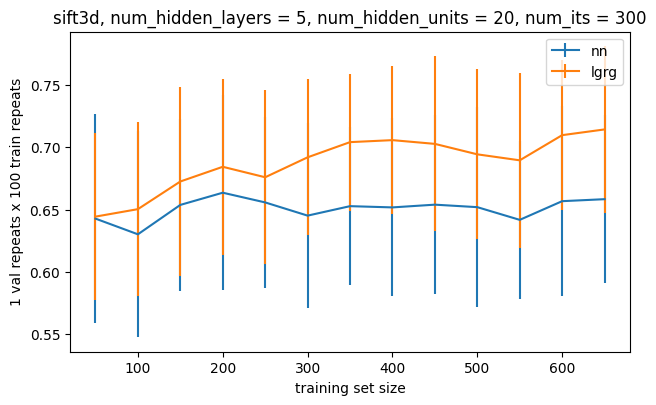

In [27]:
# unpack params
train_sizes = rnd_params['train_sizes']
val_sizes = rnd_params['val_sizes']
train_its = rnd_params['train_its']
val_its = rnd_params['val_its']
assess_qs = ['min_acc', 'val_acc', 'missed', 'false_alarm']

# read sg training curves
curves_sg = {}
errors_sg = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(res_path_nn+'curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves_sg[quantity] = curves_i[j::8].reshape((1, -1))
            errors_sg[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves_sg[quantity] = np.concatenate((curves[quantity], [curves_i[j::8]]), axis=0)
            errors_sg[quantity] = np.concatenate((errors[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2
        
# read lgrg training curves
curves_lgrg = {}
errors_lgrg = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(res_path_lgrg+'curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves_lgrg[quantity] = curves_i[j::8].reshape((1, -1))
            errors_lgrg[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves_lgrg[quantity] = np.concatenate((curves[quantity], [curves_i[j::8]]), axis=0)
            errors_lgrg[quantity] = np.concatenate((errors[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2

# plot training curves
plt.figure(figsize=(7,4))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
for i in range(len(val_sizes)):
    plt.subplot(len(val_sizes), 1, i+1)
    plt.errorbar(train_sizes, curves_sg['val_acc'][i], errors_sg['val_acc'][i])
    plt.errorbar(train_sizes, curves_lgrg['val_acc'][i], errors_lgrg['val_acc'][i])
    plt.legend(['nn', 'lgrg'])
    plt.xlabel('training set size')
    plt.ylabel('{} val repeats x {} train repeats'.format(val_its, train_its))
    _ = plt.title('{}, num_hidden_layers = {}, num_hidden_units = {}, num_its = {}'.format(data_params['feature_id'], nn_params['num_hidden_layers'], nn_params['num_hidden_units'], nn_opt_params['num_its']))
plt.savefig(res_path_nn+'val_acc_compare.png')

# Add the main experiment's curves

## Save the benchmark file results with their correct name before moving forward

In [28]:
def read_train_curves(val_sizes, res_path):
    assess_qs = ['min_acc', 'val_acc', 'missed', 'false_alarm']
    curves = {}
    errors = {}
    for i in range(len(val_sizes)):
        curves_i = np.loadtxt(res_path+'curves/train_'+str(i)+'.txt')
        j = 0
        for quantity in assess_qs:
            if i==0:
                curves[quantity] = curves_i[j::8].reshape((1, -1))
                errors[quantity] = curves_i[j+1::8].reshape((1, -1))
            else:
                curves[quantity] = np.concatenate((curves[quantity], [curves_i[j::8]]), axis=0)
                errors[quantity] = np.concatenate((errors[quantity], [curves_i[j+1::8]]), axis=0)
            j += 2
            
        return curves, errors

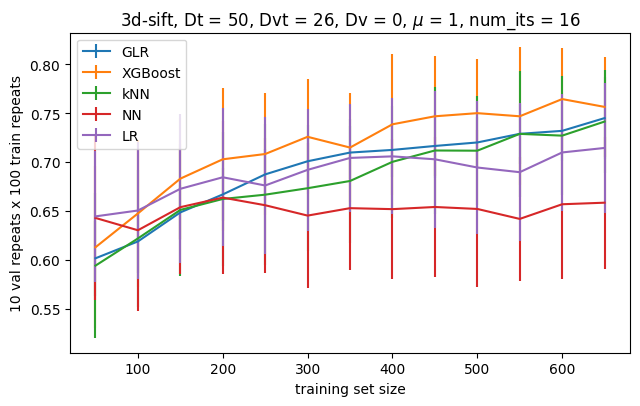

In [29]:
# set the parameters
res_path_1 = '../../data/experiments/sift3d/sift3d_sg/2023_07_11/'
res_path_2 = '../../data/experiments/comparison/2023_07_12-knn-xgb/xgb/'
res_path_3 = '../../data/experiments/comparison/2023_07_12-knn-xgb/knn/'
res_path_4 = '../../data/experiments/comparison/2023_07_12-nn-lgrg/nn/'
res_path_5 = '../../data/experiments/comparison/2023_07_12-nn-lgrg/lgrg/'
# res_path_6 = '../../data/experiments/comparison/2023_05_20-knn-xgb-1/knn/'
rnd_params = {'train_sizes': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650], 'val_sizes': [100], 'train_its': 100, 'val_its': 10, 'seed': None}
legend = ['GLR','XGBoost','kNN','NN', 'LR']
title = '3d-sift, Dt = 50, Dvt = 26, Dv = 0, $\mu$ = 1, num_its = 16'


# unpack params
train_sizes = rnd_params['train_sizes']
val_sizes = rnd_params['val_sizes']
train_its = rnd_params['train_its']
val_its = rnd_params['val_its']

# read training curves
curves_1, errors_1 = read_train_curves(val_sizes, res_path_1)
curves_2, errors_2 = read_train_curves(val_sizes, res_path_2)
curves_3, errors_3 = read_train_curves(val_sizes, res_path_3)
curves_4, errors_4 = read_train_curves(val_sizes, res_path_4)
curves_5, errors_5 = read_train_curves(val_sizes, res_path_5)
# curves_6, errors_6 = read_train_curves(val_sizes, res_path_6)

# plot training curves
plt.figure(figsize=(7,4))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
for i in range(len(val_sizes)):
    plt.subplot(len(val_sizes), 1, i+1)
    plt.errorbar(train_sizes, curves_1['val_acc'][i], errors_1['val_acc'][i])
    plt.errorbar(train_sizes, curves_2['val_acc'][i], errors_2['val_acc'][i])
    plt.errorbar(train_sizes, curves_3['val_acc'][i], errors_3['val_acc'][i])
    plt.errorbar(train_sizes, curves_4['val_acc'][i], errors_4['val_acc'][i])
    plt.errorbar(train_sizes, curves_5['val_acc'][i], errors_5['val_acc'][i])
    # plt.errorbar(train_sizes, curves_6['val_acc'][i], errors_6['val_acc'][i])
    plt.legend(legend)
    plt.xlabel('training set size')
    plt.ylabel('{} val repeats x {} train repeats'.format(val_its, train_its))
    _ = plt.title(title)
plt.savefig(res_path_1+'benchmark.png')